In [42]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

import keras
import numpy as np
import pandas as pd

import enigma_model as em

In [1]:
# lines = open('fra.txt', encoding='utf-8').read().split('\n')

In [43]:
nb_samples = 1<<15
plain, cipher = em.generate_data(nb_samples)
enigma_data = pd.DataFrame({'PLAIN': plain, 'CIPHER': cipher})
enigma_data.head()

,PLAIN,CIPHER
0,HEARCANBLACKROLE,GAHBETYTBVMJMEHG
1,TOTALMEANMOVIEEATBACKPOINT,ZMJIAPWPHYBNUOJOVQDVVHEGHK
2,EDGEORGANIZATIONUSEMISSAGENCY,XSYKTWQPHHHGCDCYEUCUNQCLBXXJR
3,SEATMENTIONWHITEHANDRECENTLY,UAHORZYBVTJQYDXGDNOPQOSNHKHS
4,SAFELEFTLETTALKWHENPREPARE,UEMKAZJBBQEPDVAXDLODQORLXX


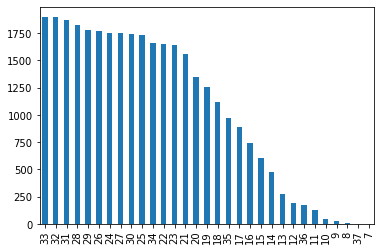

In [44]:
!pip install matplotlib
import matplotlib
enigma_data['PLAIN'].str.len().value_counts().plot(kind='bar')

In [45]:
eng_sent = []
fra_sent = []
eng_chars = set()
fra_chars = set()
# nb_samples = enigma_data.shape[0]

# Process english and french sentences
for index, row in enigma_data.iterrows():
#     eng_line = str(lines[line]).split('\t')[0]
    eng_line = str(row['PLAIN'])
    
    # Append '\t' for start of the sentence and '\n' to signify end of the sentence
#     fra_line = '\t' + str(lines[line]).split('\t')[1] + '\n'
    fra_line = f"\t{str(row['CIPHER'])}\n"
    
    eng_sent.append(eng_line)
    fra_sent.append(fra_line)
    
    for ch in eng_line:
        if (ch not in eng_chars):
            eng_chars.add(ch)
            
    for ch in fra_line:
        if (ch not in fra_chars):
            fra_chars.add(ch)

In [46]:
enigma_data.head()

,PLAIN,CIPHER
0,HEARCANBLACKROLE,GAHBETYTBVMJMEHG
1,TOTALMEANMOVIEEATBACKPOINT,ZMJIAPWPHYBNUOJOVQDVVHEGHK
2,EDGEORGANIZATIONUSEMISSAGENCY,XSYKTWQPHHHGCDCYEUCUNQCLBXXJR
3,SEATMENTIONWHITEHANDRECENTLY,UAHORZYBVTJQYDXGDNOPQOSNHKHS
4,SAFELEFTLETTALKWHENPREPARE,UEMKAZJBBQEPDVAXDLODQORLXX


In [47]:
fra_chars = sorted(list(fra_chars))
eng_chars = sorted(list(eng_chars))

In [48]:
print(eng_sent[0:2])
print(fra_sent[0:2])
print(eng_chars)
print(fra_chars)

['HEARCANBLACKROLE', 'TOTALMEANMOVIEEATBACKPOINT']
['\tGAHBETYTBVMJMEHG\n', '\tZMJIAPWPHYBNUOJOVQDVVHEGHK\n']
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
['\t', '\n', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [49]:
# dictionary to index each english character - key is index and value is english character
eng_index_to_char_dict = {}

# dictionary to get english character given its index - key is english character and value is index
eng_char_to_index_dict = {}

for k, v in enumerate(eng_chars):
    eng_index_to_char_dict[k] = v
    eng_char_to_index_dict[v] = k

In [50]:
# dictionary to index each french character - key is index and value is french character
fra_index_to_char_dict = {}

# dictionary to get french character given its index - key is french character and value is index
fra_char_to_index_dict = {}
for k, v in enumerate(fra_chars):
    fra_index_to_char_dict[k] = v
    fra_char_to_index_dict[v] = k

In [51]:
max_len_eng_sent = max([len(line) for line in eng_sent])
max_len_fra_sent = max([len(line) for line in fra_sent])

In [52]:
print(max_len_eng_sent)
print(max_len_fra_sent)

37
39


In [53]:
tokenized_eng_sentences = np.zeros(shape = (nb_samples,max_len_eng_sent,len(eng_chars)), dtype='float32')
tokenized_fra_sentences = np.zeros(shape = (nb_samples,max_len_fra_sent,len(fra_chars)), dtype='float32')
target_data = np.zeros((nb_samples, max_len_fra_sent, len(fra_chars)),dtype='float32')

In [54]:
# Vectorize the english and french sentences

for i in range(nb_samples):
    for k,ch in enumerate(eng_sent[i]):
        tokenized_eng_sentences[i,k,eng_char_to_index_dict[ch]] = 1
        
    for k,ch in enumerate(fra_sent[i]):
        tokenized_fra_sentences[i,k,fra_char_to_index_dict[ch]] = 1

        # decoder_target_data will be ahead by one timestep and will not include the start character.
        if k > 0:
            target_data[i,k-1,fra_char_to_index_dict[ch]] = 1

In [55]:
# Encoder model

encoder_input = Input(shape=(None,len(eng_chars)))
encoder_LSTM = LSTM(256,return_state = True)
encoder_outputs, encoder_h, encoder_c = encoder_LSTM (encoder_input)
encoder_states = [encoder_h, encoder_c]


In [56]:
# Decoder model

decoder_input = Input(shape=(None,len(fra_chars)))
decoder_LSTM = LSTM(256,return_sequences=True, return_state = True)
decoder_out, _ , _ = decoder_LSTM(decoder_input, initial_state=encoder_states)
decoder_dense = Dense(len(fra_chars),activation='softmax')
decoder_out = decoder_dense(decoder_out)


In [67]:
model = Model(inputs=[encoder_input, decoder_input],outputs=[decoder_out])

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# filepath = './enigma_best_model.h5'

# checkpoint = keras.callbacks.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
# # reduce_lr = keras.callbacks.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.0001, verbose=2)
# earlystopping = keras.callbacks.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose=2, mode='auto')
# callbacks = [checkpoint , earlystopping]

model.fit(x=[tokenized_eng_sentences,tokenized_fra_sentences], 
          y=target_data,
          batch_size=64,
          epochs=2,
          
          validation_split=0.2)

Train on 26214 samples, validate on 6554 samples
Epoch 1/2
26214/26214 [==============================] - 59s 2ms/step - loss: 0.9381 - val_loss: 1.3295
Epoch 2/2
26214/26214 [==============================] - 62s 2ms/step - loss: 0.9312 - val_loss: 1.3329


dict_keys(['val_loss', 'loss'])


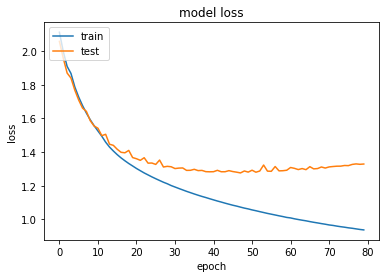

In [58]:
import matplotlib.pyplot as plt

print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [68]:
# Inference models for testing

# Encoder inference model
encoder_model_inf = Model(encoder_input, encoder_states)

# Decoder inference model
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_input_states = [decoder_state_input_h, decoder_state_input_c]

decoder_out, decoder_h, decoder_c = decoder_LSTM(decoder_input, initial_state=decoder_input_states)
decoder_states = [decoder_h , decoder_c]

decoder_out = decoder_dense(decoder_out)

decoder_model_inf = Model(inputs=[decoder_input] + decoder_input_states,outputs=[decoder_out] + decoder_states )


ValueError: Layer lstm_6 expects 17 inputs, but it received 3 input tensors. Input received: [<tf.Tensor 'input_6:0' shape=(?, ?, 28) dtype=float32>, <tf.Tensor 'input_21:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'input_22:0' shape=(?, 256) dtype=float32>]

In [43]:
def decode_seq(inp_seq):
    
    # Initial states value is coming from the encoder 
    states_val = encoder_model_inf.predict(inp_seq)
    
    target_seq = np.zeros((1, 1, len(fra_chars)))
    target_seq[0, 0, fra_char_to_index_dict['\t']] = 1
    
    translated_sent = ''
    stop_condition = False
    
    while not stop_condition:
        
        decoder_out, decoder_h, decoder_c = decoder_model_inf.predict(x=[target_seq] + states_val)
        
        max_val_index = np.argmax(decoder_out[0,-1,:])
        sampled_fra_char = fra_index_to_char_dict[max_val_index]
        translated_sent += sampled_fra_char
        
        if ( (sampled_fra_char == '\n') or (len(translated_sent) > max_len_fra_sent)) :
            stop_condition = True
        
        target_seq = np.zeros((1, 1, len(fra_chars)))
        target_seq[0, 0, max_val_index] = 1
        
        states_val = [decoder_h, decoder_c]
        
    return translated_sent



In [94]:
def decode_seq2(n, inp_seq):
    
    # Initial states value is coming from the encoder 
    states_val = encoder_model_inf.predict(inp_seq)
    
    target_seq = np.zeros((1, 1, len(fra_chars)))
    target_seq[0, 0, fra_char_to_index_dict['\t']] = 1
    
    translated_sent = ''
    
    for i in range(n):
        
        decoder_out, decoder_h, decoder_c = decoder_model_inf.predict(x=[target_seq] + states_val)
        
        max_val_index = np.argmax(decoder_out[0,0,:])
        sampled_fra_char = fra_index_to_char_dict[max_val_index]
        translated_sent += sampled_fra_char
        
        print(translated_sent)
        
#         if ( (sampled_fra_char == '\n') or (len(translated_sent) > max_len_fra_sent)) :
#             stop_condition = True
        
        target_seq = np.zeros((1, 1, len(fra_chars)))
        target_seq[0, 0, max_val_index] = 1
        
        states_val = [decoder_h, decoder_c]
        
    return translated_sent

seq_index = 0
inp_seq = tokenized_eng_sentences[seq_index:seq_index+1]
translated_sent = decode_seq2(n=10, inp_seq=inp_seq)

D
DM
DMH
DMHC
DMHCW
DMHCWZ
DMHCWZW
DMHCWZWY
DMHCWZWYC
DMHCWZWYCS


In [44]:
enigma_data.head()

,PLAIN,CIPHER
0,FARQUICKLYPERFORMSOMECHANGEDAY,JEXNBVMQBMQOMBCDOUNUCIFLHPGMJH
1,COACHIMPACTPMLAWYERADMITYET,VMHDXVCAQFETRVKXNLPGLWQBZXO
2,FRONTTHEMPERSONAL,JGBQOAUVWLTBFEQOS
3,GOMONTHWELLALTHOUGHEVENING,HMFTYAUSCPYGXULAERJIKOGGHP
4,WONDEREVENFUTUREOILCOMPANYGROWBORN,IMPCCWWECSSCCTSGMFUVTWRLHOELUEYVHF


In [45]:
predicted_cipher = []
actual_cipher = []

for seq_index in range(10):
    inp_seq = tokenized_eng_sentences[seq_index:seq_index+1]
    translated_sent = decode_seq(inp_seq)
    predicted_cipher.append(translated_sent)
    actual_cipher.append(enigma_data['CIPHER'][seq_index])
    
    print('-' * 100)
    print('Input sentence:', eng_sent[seq_index])
    print('Decoded sentence:', translated_sent.strip())
    print('Decoded original:', enigma_data['CIPHER'][seq_index])


    
# def predict(cipher_list: List[str]) -> List[str]:
#     # solution here
#     # uses part of the data to train
#     # then uses the rest of the data to predict the cipher with .9  acc 
#     predicted_plain = cipher_list
#     # print(f" len cipher {len(predicted_plain)}")
#     # print(print(predicted_plain[1:2]))

#     # TODO: import test() from model.py and for each cipher in test predict and append to ret_list
#     return predicted_plain
   
    
def str_score(str_a: str, str_b: str) -> float:
    if len(str_a) != len(str_b):
        return 0

    n_correct = 0

    for a, b in zip(str_a, str_b):
        n_correct += int(a == b)
    # print(f" n_correct {n_correct}")
    # print(f" len  {n_correct}")

    return n_correct / len(str_a)

    
def score(predicted_plain: List[str], correct_plain: List[str]) -> float:
    correct = 0

    for p, c in zip(predicted_plain, correct_plain):
        # print(p,c)
        # exit()
        if str_score(p, c) > 0.8:
            correct += 1
    print(f" correct {correct}")
    print(f" len correct_plain {len(correct_plain)}")

    return correct / len(correct_plain)


print(score(predicted_cipher, actual_cipher ))


----------------------------------------------------------------------------------------------------
Input sentence: FARQUICKLYPERFORMSOMECHANGEDAY
Decoded sentence: ZEJOLWWYYQUOMOJGULPIQOPBIIGHKQ
----------------------------------------------------------------------------------------------------
Input sentence: COACHIMPACTPMLAWYERADMITYET
Decoded sentence: ZEXKWYYVQSTOBOJGVLPIQOPBIIG
----------------------------------------------------------------------------------------------------
Input sentence: FRONTTHEMPERSONAL
Decoded sentence: ZNBYMZXVQSTOMOFCU
----------------------------------------------------------------------------------------------------
Input sentence: GOMONTHWELLALTHOUGHEVENING
Decoded sentence: ZEJKWYYVQSTOMOJGULPIQOPBII
----------------------------------------------------------------------------------------------------
Input sentence: WONDEREVENFUTUREOILCOMPANYGROWBORN
Decoded sentence: UMJKWYYVQSTOMOJGULPIQXXNXXVKJZKGVQ
-----------------------------------------------

In [183]:
def predict(cipher_list: List[str]) -> List[str]:
    # solution here
    # uses part of the data to train
    # then uses the rest of the data to predict the cipher with .9  acc 
    predicted_plain = cipher_list
    # print(f" len cipher {len(predicted_plain)}")
    # print(print(predicted_plain[1:2]))

    # TODO: import test() from model.py and for each cipher in test predict and append to ret_list
    return predicted_plain


def str_score(str_a: str, str_b: str) -> float:
    if len(str_a) != len(str_b):
        return 0

    n_correct = 0

    for a, b in zip(str_a, str_b):
        n_correct += int(a == b)
    # print(f" n_correct {n_correct}")
    # print(f" len  {n_correct}")

    return n_correct / len(str_a)


def score(predicted_plain: List[str], correct_plain: List[str]) -> float:
    correct = 0

    for p, c in zip(predicted_plain, correct_plain):
        # print(p,c)
        # exit()
        if str_score(p, c) > 0.8:
            correct += 1
    print(f" correct {correct}")
    print(f" len correct_plain {len(correct_plain)}")

    return correct / len(correct_plain)



['\tVa !\n',
 '\tCours\u202f!\n',
 '\tCourez\u202f!\n',
 '\tÇa alors\u202f!\n',
 '\tAu feu !\n',
 "\tÀ l'aide\u202f!\n",
 '\tSaute.\n',
 '\tÇa suffit\u202f!\n',
 '\tStop\u202f!\n',
 '\tArrête-toi !\n',
 '\tAttends !\n',
 '\tAttendez !\n',
 '\tJe comprends.\n',
 "\tJ'essaye.\n",
 "\tJ'ai gagné !\n",
 "\tJe l'ai emporté !\n",
 '\tOh non !\n',
 '\tAttaque !\n',
 '\tAttaquez !\n',
 '\tSanté !\n',
 '\tÀ votre santé !\n',
 '\tMerci !\n',
 '\tTchin-tchin !\n',
 '\tLève-toi.\n',
 "\tJ'ai pigé !\n",
 '\tCompris !\n',
 '\tPigé\u202f?\n',
 '\tCompris\u202f?\n',
 "\tT'as capté\u202f?\n",
 '\tMonte.\n',
 '\tMontez.\n',
 '\tSerre-moi dans tes bras !\n',
 '\tSerrez-moi dans vos bras !\n',
 '\tJe suis tombée.\n',
 '\tJe suis tombé.\n',
 '\tJe sais.\n',
 '\tJe suis parti.\n',
 '\tJe suis partie.\n',
 "\tJ'ai perdu.\n",
 "\tJ'ai 19 ans.\n",
 '\tJe vais bien.\n',
 '\tÇa va.\n',
 '\tÉcoutez !\n',
 "\tC'est pas possible\u202f!\n",
 '\tImpossible\u202f!\n',
 '\tEn aucun cas.\n',
 "\tC'est hors de question !

In [ ]:
print(score(predict(cipher), plain))